## Prelimiary Operations

### Useful operations

In [100]:
import os
import shutil
if os.path.exists("/kaggle/working/andrea"):
    shutil.rmtree("/kaggle/working/andrea")

In [101]:
# if os.path.exists("/kaggle/working/Xception_experiments"):
    # shutil.rmtree("/kaggle/working/Xception_experiments")

In [102]:
# if os.path.exists("/kaggle/working/Xception"):
    # shutil.rmtree("/kaggle/working/Xception")

In [103]:
#if os.path.exists("/kaggle/working/Xception"):
#    shutil.rmtree("/kaggle/working/Xception")

In [104]:
# to remove a file
import os
if os.path.exists("/kaggle/working/model.png"):
    os.remove("/kaggle/working/model.png")

In [105]:
# to create a folder
import os
directory = "Xception"
parent_dir = "/kaggle/working"
path = os.path.join(parent_dir, directory)
if not os.path.exists(path):
    os.mkdir(path)

### Operations

In [106]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image

tfk = tf.keras
tfkl = tf.keras.layers

In [107]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [108]:
import warnings
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

## Importing data

In [109]:
labels = ['Species1',   # 0
          'Species2',   # 1
          'Species3',   # 2
          'Species4',   # 3
          'Species5',   # 4
          'Species6',   # 5
          'Species7',   # 6
          'Species8']   # 7

In [110]:
# Dataset folders 
dataset_dir = "../input/splitted-dataset-no-test/splitted_dataset_no_test"
training_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'val')

In [111]:
# Images are divided into folders, one for each class. 
# If the images are organized in such a way, we can exploit the 
# ImageDataGenerator to read them from disk.
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an instance of ImageDataGenerator, and for the trainign with Data Augmentation
# Use this for data augmentation. With rescaling normalization
"""
train_data_gen = ImageDataGenerator(rotation_range=10,
                                        height_shift_range=10,
                                        width_shift_range=10,
                                        zoom_range=0.1,
                                        horizontal_flip=True,
                                        fill_mode='reflect',
                                        rescale=1/255.)
"""
# Use this for no data augmentation. Rescaling normalization
train_data_gen = ImageDataGenerator(rescale=1/255.)
valid_data_gen = ImageDataGenerator(rescale=1/255.)

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
train_gen = train_data_gen.flow_from_directory(directory=training_dir,
                                                       target_size=(96,96),
                                                       color_mode='rgb',
                                                       classes=None, # can be set to labels
                                                       class_mode='categorical',
                                                       batch_size=8,
                                                       shuffle=True,
                                                       seed=seed)

valid_gen = valid_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(96,96),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=8,
                                               shuffle=False,
                                               seed=seed)

Found 3432 images belonging to 8 classes.
Found 864 images belonging to 8 classes.


## Model

In [114]:
!cd /kaggle/working/Xception

In [115]:
show_net = True

In [116]:
# Download and plot the Xception model
xception = tfk.applications.xception.Xception(
    include_top=False,
    weights='imagenet',
    input_shape=(96,96,3),
)

xception.trainable = False # we are freezing the weights of the conv part, so that they are not updated
                            # during the training
tfk.utils.plot_model(xception)

In [117]:
input_shape = (96, 96, 3)
epochs = 200
learning_rate = None
l1=1e-6
l2=1e-4

In [118]:
def build_model(input_shape):

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')
    
    xcep = xception(input_layer)
    
    x = tfkl.Flatten()(xcep)
    x = tfkl.Dropout(0.4, seed=seed)(x)
    x = tfkl.Dense(units=2048, name='classifier1', kernel_initializer=tfk.initializers.HeUniform(seed), activation='relu',
                  kernel_regularizer=tfk.regularizers.L1L2(l1=l1, l2=l2))(x)
    x = tfkl.Dropout(0.4, seed=seed)(x)
    x = tfkl.Dense(units=512, name='classifier2', kernel_initializer=tfk.initializers.HeUniform(seed), activation='relu',
                  kernel_regularizer=tfk.regularizers.L1L2(l1=l1, l2=l2))(x)
    x = tfkl.Dropout(0.4, seed=seed)(x)

    
    output_layer = tfkl.Dense(units=8, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='output_layer')(x)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='xception_model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

Model: "xception_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 96, 96, 3)]       0         
_________________________________________________________________
xception (Functional)        (None, 3, 3, 2048)        20861480  
_________________________________________________________________
flatten_4 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 18432)             0         
_________________________________________________________________
classifier1 (Dense)          (None, 2048)              37750784  
_________________________________________________________________
dropout_16 (Dropout)         (None, 2048)              0         
_________________________________________________________________
classifier2 (Dense)          (None, 512)            

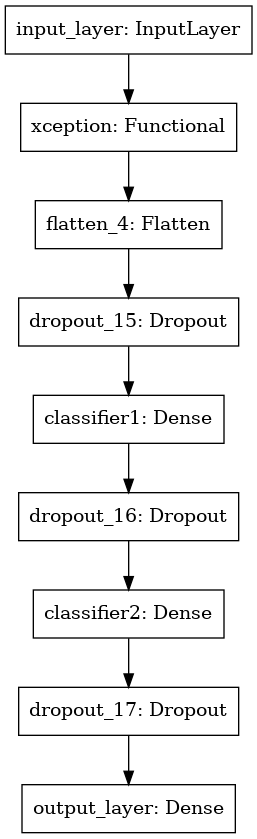

In [119]:
# Build model
xc_model = build_model(input_shape)
xc_model.summary()
tfk.utils.plot_model(xc_model)

In [120]:
xc_model.get_layer('xception').trainable = True

In [121]:
# Keep the last N layers trainable and freeze all the thers
N = -47

for i, layer in enumerate(xc_model.get_layer('xception').layers[:N]):
  layer.trainable=False
for i, layer in enumerate(xc_model.get_layer('xception').layers):
   print(i, layer.name, layer.trainable)
xc_model.summary()

0 input_5 False
1 block1_conv1 False
2 block1_conv1_bn False
3 block1_conv1_act False
4 block1_conv2 False
5 block1_conv2_bn False
6 block1_conv2_act False
7 block2_sepconv1 False
8 block2_sepconv1_bn False
9 block2_sepconv2_act False
10 block2_sepconv2 False
11 block2_sepconv2_bn False
12 conv2d_16 False
13 block2_pool False
14 batch_normalization_16 False
15 add_48 False
16 block3_sepconv1_act False
17 block3_sepconv1 False
18 block3_sepconv1_bn False
19 block3_sepconv2_act False
20 block3_sepconv2 False
21 block3_sepconv2_bn False
22 conv2d_17 False
23 block3_pool False
24 batch_normalization_17 False
25 add_49 False
26 block4_sepconv1_act False
27 block4_sepconv1 False
28 block4_sepconv1_bn False
29 block4_sepconv2_act False
30 block4_sepconv2 False
31 block4_sepconv2_bn False
32 conv2d_18 False
33 block4_pool False
34 batch_normalization_18 False
35 add_50 False
36 block5_sepconv1_act False
37 block5_sepconv1 False
38 block5_sepconv1_bn False
39 block5_sepconv2_act False
40 block5

## Training

In [122]:
patience = 20

In [123]:
model_name = "Xception_fine_tuning_-4_block_non_trainable"

In [124]:
# Train the model
xc_history = xc_model.fit(
    x = train_gen,
    batch_size = 256,
    epochs = 200,
    validation_data = valid_gen,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_loss', mode='max', patience=patience, restore_best_weights=True)],
).history

Epoch 1/200
429/429 [==============================] - 15s 27ms/step - loss: 2.5654 - accuracy: 0.3354 - val_loss: 2.1557 - val_accuracy: 0.4387
Epoch 2/200
429/429 [==============================] - 11s 26ms/step - loss: 2.1205 - accuracy: 0.4819 - val_loss: 2.0090 - val_accuracy: 0.5382
Epoch 3/200
429/429 [==============================] - 11s 25ms/step - loss: 1.9935 - accuracy: 0.5530 - val_loss: 2.0534 - val_accuracy: 0.5359
Epoch 4/200
429/429 [==============================] - 11s 25ms/step - loss: 1.9117 - accuracy: 0.5956 - val_loss: 2.0820 - val_accuracy: 0.5856
Epoch 5/200
429/429 [==============================] - 11s 26ms/step - loss: 1.9729 - accuracy: 0.6253 - val_loss: 2.1710 - val_accuracy: 0.6007
Epoch 6/200
429/429 [==============================] - 11s 25ms/step - loss: 1.9117 - accuracy: 0.6681 - val_loss: 2.1487 - val_accuracy: 0.6285
Epoch 7/200
429/429 [==============================] - 11s 25ms/step - loss: 1.8396 - accuracy: 0.6906 - val_loss: 2.1153 - val_ac

KeyboardInterrupt: 

The model was stopped since the performance were very poor compared to the results obtained before.

In [ ]:
# Plot the training
plt.figure(figsize=(15,5))
plt.plot(xc_history['loss'], label='Loss', alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(xc_history['val_loss'], label='Val loss', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)
plt.savefig(model_name + "cat_cr_en.png")

plt.figure(figsize=(15,5))
plt.plot(xc_history['accuracy'], label='Accuracy', alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(xc_history['val_accuracy'], label='Val accuracy', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)
plt.savefig(model_name + "acc.png")

plt.show()

In [ ]:
# Save the best model
xc_model.save(model_name)

In [ ]:
# Evaluate on val
val_metrics = xc_model.evaluate(valid_gen, return_dict=True)

print()
print("Val metrics")
print(val_metrics)

In [ ]:
import shutil
shutil.make_archive(model_name, 'zip', "/kaggle/working/Xception")